In [1]:
import numpy as np
import tensorflow as tf

import utils

In [2]:
TRAIN_TEST_SPLIT = 1000
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFER_BUFFER_SIZE = 1000

In [3]:
series = utils.generate_time_series()

time = list(range(len(series)))
time_train = time[:TRAIN_TEST_SPLIT]
x_train = series[:TRAIN_TEST_SPLIT]
time_val = time[TRAIN_TEST_SPLIT:]
x_val = series[TRAIN_TEST_SPLIT:]

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFER_BUFFER_SIZE)

In [6]:
layer = tf.keras.layers.Dense(1, input_shape=[WINDOW_SIZE])
model = tf.keras.models.Sequential([layer])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(optimizer=optimizer, loss='mse')

In [7]:
history = model.fit(dataset, epochs=100, verbose=0)

In [8]:
layer.get_weights()

[array([[-0.07547288],
        [ 0.03126869],
        [-0.02434579],
        [ 0.09032796],
        [-0.02160295],
        [ 0.02846482],
        [-0.0477467 ],
        [ 0.04529889],
        [-0.11464299],
        [ 0.13604303],
        [-0.02954057],
        [-0.00502786],
        [-0.12162364],
        [ 0.08089001],
        [ 0.0812634 ],
        [ 0.06496961],
        [-0.07372516],
        [ 0.22467723],
        [ 0.24595882],
        [ 0.46424645]], dtype=float32), array([0.01699228], dtype=float32)]

In [9]:
forecasts = []
for t in time_val:
    x = series[t-WINDOW_SIZE:t]
    forecast = model.predict(np.expand_dims(x, 0))[0][0]
    forecasts.append(forecast)

In [10]:
utils.evaluate(x_val, forecasts)

mse = 51.0741, mae = 5.2816


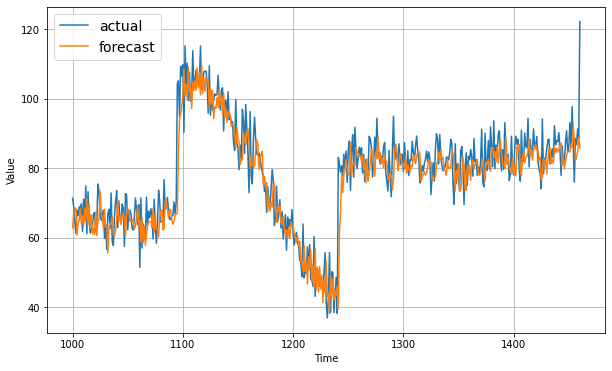

In [11]:
utils.plot_series(time_val, [x_val, forecasts], label=['actual', 'forecast'])